# NLP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import pickle
import re

import nltk
from nltk.corpus import stopwords
import requests
from bson.objectid import ObjectId

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import os
import codecs
from sklearn import feature_extraction
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import json
from pymongo import MongoClient

In [4]:
# Retrieve data from Mongo
client = MongoClient()
db = client.property_investor
listings = db.listings
cursor = listings.find()
listing_df = pd.DataFrame(list(cursor))

In [5]:
listing_text = []
for listing in listings.find():
    try:
        if len(listing['description_text']) > 3:
            listing_text.append(listing['description_text'])
    except:
        pass

listing_text

['Great investment opportunity in the heart of Uptown! Brick 4-plex with four 1 bedroom, 1 bath apartments. Formal dining rooms, hardwood floors, natural woodwork and built-ins. Shared front decks, separate utilities and assigned off-street parking in back.  ',
 'New windows, siding, foundation, updated bathrooms, fresh paint, carpet and graveled driveway. Vinyl flooring and updated plumbing! Separate entrance duplex! Longfellow community, close to quaint shops and dining, easy highway access! ',
 'great investment property , great location. Currently rented month to month. 2 bedrooms each unit, 4 car garage. Information deemed Reliable but not Guaranteed.  ',
 "Beautiful Audobon Park duplex that is owner occupied  &  has been rehabbed beautifully. One of the highest points in Hennepin County, you can see for miles from the back decks. The owner's unit is the main floor  &  basement  &  has 4 BR's, 2 BA's with the lower level set up as a mother-in-law apartment. See photos. The upper u

In [6]:
num_listings = len(listing_text)
print(num_listings)

391


## Text Blob

In [7]:
from textblob import TextBlob

In [8]:
for listing in listing_text[:10]:
    print(TextBlob(listing).sentiment)
    print(listing)
    print('\n')

Sentiment(polarity=0.3666666666666667, subjectivity=0.3833333333333333)
Great investment opportunity in the heart of Uptown! Brick 4-plex with four 1 bedroom, 1 bath apartments. Formal dining rooms, hardwood floors, natural woodwork and built-ins. Shared front decks, separate utilities and assigned off-street parking in back.  


Sentiment(polarity=0.38226010101010105, subjectivity=0.595959595959596)
New windows, siding, foundation, updated bathrooms, fresh paint, carpet and graveled driveway. Vinyl flooring and updated plumbing! Separate entrance duplex! Longfellow community, close to quaint shops and dining, easy highway access! 


Sentiment(polarity=0.5333333333333333, subjectivity=0.6333333333333333)
great investment property , great location. Currently rented month to month. 2 bedrooms each unit, 4 car garage. Information deemed Reliable but not Guaranteed.  


Sentiment(polarity=0.3111111111111111, subjectivity=0.5555555555555556)
Beautiful Audobon Park duplex that is owner occup

In [9]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

realestate_words = ['property', 'units', 'great', 'floors', 'build', 'bedroom', 'bedrooms', 'bath', 'kitchens',\
                    'kitchen', 'unit', 'floor', 'built', 'property\'', 'tenant', 'flat', 'rooms', 'properties'\
                   'full', 'building', 'room', 'basement']

# Add real estate stop words
for word in realestate_words:
    stopwords.append(word)

In [10]:
def listing_to_joined_words( raw_listing ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw property description), and 
    # the output is a single string (a preprocessed property description)
    #
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_listing) 
    #
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords)                  
    # 
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

def listing_to_words( raw_listing ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_listing) 
    #
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords)                  
    # 
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # Join the words back into one string separated by space, 
    # and return the result.
    return meaningful_words

In [11]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
# Initialize an empty list to hold the clean listings
clean_listings = []

# Loop over each listing; create an index i that goes from 0 to the length
# of the listing list 
print("Cleaning and parsing the listings...\n")
for i in range( 0, num_listings ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    if( (i+1)%100 == 0 ):
        print("Listing %d of %d\n" % ( i+1, num_listings ))
    clean_listings.append( listing_to_joined_words( listing_text[i] ) )

Cleaning and parsing the listings...

Listing 100 of 391

Listing 200 of 391

Listing 300 of 391



In [13]:
clean_listings[:3]

['investment opportunity heart uptown brick plex four apartments formal dining hardwood natural woodwork ins shared front decks separate utilities assigned street parking back',
 'new windows siding foundation updated bathrooms fresh paint carpet graveled driveway vinyl flooring updated plumbing separate entrance duplex longfellow community close quaint shops dining easy highway access',
 'investment location currently rented month month car garage information deemed reliable guaranteed']

In [14]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=stopwords, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit_transform(clean_listings)

<391x9685 sparse matrix of type '<class 'numpy.int64'>'
	with 21529 stored elements in Compressed Sparse Row format>

In [15]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(clean_listings).transpose()
counts

<9685x391 sparse matrix of type '<class 'numpy.int64'>'
	with 21529 stored elements in Compressed Sparse Column format>

In [16]:
# Take a look at the words in the vocabulary
vocab = count_vectorizer.get_feature_names()
print(vocab)

['able', 'able afford', 'able apartment', 'able lot', 'absolute', 'absolute money', 'absolutely', 'absolutely gorgeous', 'absolutely updated', 'abundance', 'abundance natural', 'abundant', 'ac', 'ac heat', 'ac long', 'ac windows', 'accepted', 'accepted seller', 'access', 'access city', 'access detached', 'access downtowns', 'access fenced', 'access major', 'access national', 'access recent', 'access schools', 'accessible', 'accessible public', 'accompanied', 'accompanied licensed', 'accompany', 'accompany offers', 'acquire', 'acquire solid', 'acquisition', 'acquisition buy', 'acquisition may', 'across', 'across bessemer', 'across elementary', 'across farview', 'across jewel', 'across sister', 'across street', 'active', 'active van', 'actual', 'actual rents', 'adams', 'adams park', 'add', 'add amenities', 'add investment', 'add opportunity', 'add touches', 'add value', 'added', 'added deal', 'added enclosed', 'addendum', 'addendum disclosures', 'addendum follow', 'addendum sale', 'adden

In [17]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)
corpus

In [18]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [19]:
len(id2word)

9685

In [21]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)

2017-03-09 10:34:25,603 : INFO : using symmetric alpha at 0.25
2017-03-09 10:34:25,606 : INFO : using symmetric eta at 0.000103252452246
2017-03-09 10:34:25,611 : INFO : using serial LDA version on this node
2017-03-09 10:34:25,879 : INFO : running online LDA training, 4 topics, 10 passes over the supplied corpus of 391 documents, updating model once every 391 documents, evaluating perplexity every 391 documents, iterating 50x with a convergence threshold of 0.001000
2017-03-09 10:34:28,088 : INFO : -10.680 per-word bound, 1641.1 perplexity estimate based on a held-out corpus of 391 documents with 22545 words
2017-03-09 10:34:28,090 : INFO : PROGRESS: pass 0, at document #391/391
2017-03-09 10:34:28,986 : INFO : topic #0 (0.250): 0.012*"new" + 0.005*"brick" + 0.004*"two" + 0.004*"full" + 0.003*"large" + 0.003*"one" + 0.003*"newer" + 0.003*"windows" + 0.003*"roof" + 0.003*"garage"
2017-03-09 10:34:28,988 : INFO : topic #1 (0.250): 0.004*"new" + 0.003*"large" + 0.003*"brick" + 0.003*"opp

In [22]:
lda.print_topics()

2017-03-09 10:34:50,694 : INFO : topic #0 (0.250): 0.011*"new" + 0.005*"brick" + 0.004*"full" + 0.004*"large" + 0.003*"two" + 0.003*"one" + 0.003*"garage" + 0.003*"newer" + 0.003*"windows" + 0.003*"roof"
2017-03-09 10:34:50,697 : INFO : topic #1 (0.250): 0.003*"new" + 0.003*"occupied" + 0.003*"tenants" + 0.003*"brick" + 0.003*"close" + 0.003*"opportunity" + 0.002*"large" + 0.002*"owner" + 0.002*"one" + 0.002*"investment"
2017-03-09 10:34:50,699 : INFO : topic #2 (0.250): 0.006*"new" + 0.006*"brick" + 0.005*"full" + 0.004*"two" + 0.004*"living" + 0.004*"garage" + 0.003*"separate" + 0.003*"car" + 0.003*"located" + 0.003*"income"
2017-03-09 10:34:50,701 : INFO : topic #3 (0.250): 0.012*"new" + 0.003*"opportunity" + 0.003*"two" + 0.003*"one" + 0.003*"owner" + 0.003*"separate" + 0.003*"cash" + 0.003*"features" + 0.003*"brick" + 0.002*"faucets"


[(0,
  '0.011*"new" + 0.005*"brick" + 0.004*"full" + 0.004*"large" + 0.003*"two" + 0.003*"one" + 0.003*"garage" + 0.003*"newer" + 0.003*"windows" + 0.003*"roof"'),
 (1,
  '0.003*"new" + 0.003*"occupied" + 0.003*"tenants" + 0.003*"brick" + 0.003*"close" + 0.003*"opportunity" + 0.002*"large" + 0.002*"owner" + 0.002*"one" + 0.002*"investment"'),
 (2,
  '0.006*"new" + 0.006*"brick" + 0.005*"full" + 0.004*"two" + 0.004*"living" + 0.004*"garage" + 0.003*"separate" + 0.003*"car" + 0.003*"located" + 0.003*"income"'),
 (3,
  '0.012*"new" + 0.003*"opportunity" + 0.003*"two" + 0.003*"one" + 0.003*"owner" + 0.003*"separate" + 0.003*"cash" + 0.003*"features" + 0.003*"brick" + 0.002*"faucets"')]

### Kmeans

In [62]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in clean_listings:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [24]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 11550 items in vocab_frame


In [25]:
print(vocab_frame.head())
print
print
print
print

                words
invest     investment
opportun  opportunity
heart           heart
uptown         uptown
brick           brick


<function print>

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(listing_text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 1.06 s, sys: 17.4 ms, total: 1.07 s
Wall time: 1.13 s
(391, 9)


In [27]:
terms = tfidf_vectorizer.get_feature_names()

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [49]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 234 ms, sys: 11.6 ms, total: 246 ms
Wall time: 253 ms


In [50]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [51]:
Inertia = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(tfidf_matrix)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(tfidf_matrix, labels, metric='euclidean'))
    Inertia.append(km.inertia_)

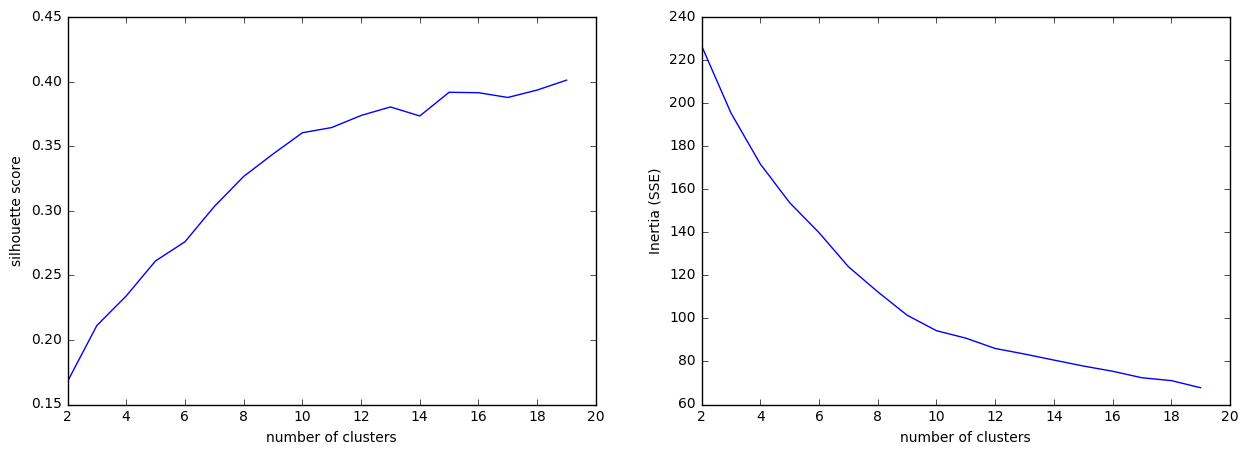

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette score')

# plot here on ax2
ax2.plot(k_clusters, Inertia)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia (SSE)');

In [53]:
tfidf_matrix

<391x9 sparse matrix of type '<class 'numpy.float64'>'
	with 871 stored elements in Compressed Sparse Row format>

In [54]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

# joblib.dump(km,  '../data/processed/listing_cluster.pkl')

# km = joblib.load('../data/processed/listing_cluster.pkl')

In [55]:
len(clusters)

391

In [56]:
listings = { 'listing_text': listing_text, 'cluster': clusters }

frame = pd.DataFrame(listings, index = [clusters] , columns = ['cluster'])

In [57]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

2    58
6    49
1    48
9    38
8    38
5    38
3    37
7    35
4    25
0    25
Name: cluster, dtype: int64

In [58]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'rented', b'rehabbed', b'properties', b'opportunity', b'new', b'living', b'garage', b'full', b'brick',

Cluster 1 words: b'properties', b'brick', b'new', b'opportunity', b'full', b'living', b'rehabbed', b'rented', b'garage',

Cluster 2 words: b'living', b'new', b'properties', b'brick', b'full', b'rehabbed', b'garage', b'rented', b'opportunity',

Cluster 3 words: b'full', b'brick', b'garage', b'living', b'new', b'rehabbed', b'properties', b'opportunity', b'rented',

Cluster 4 words: b'rented', b'brick', b'new', b'garage', b'opportunity', b'full', b'rehabbed', b'properties', b'living',

Cluster 5 words: b'new', b'rehabbed', b'brick', b'living', b'garage', b'rented', b'opportunity', b'full', b'properties',

Cluster 6 words: b'garage', b'new', b'properties', b'rented', b'full', b'living', b'rehabbed', b'opportunity', b'brick',

Cluster 7 words: b'opportunity', b'brick', b'full', b'living', b'garage', b'rehabbed', b'rented', b'properties', b'new',



In [59]:
from collections import Counter
Counter(clusters)

Counter({0: 25, 1: 48, 2: 58, 3: 37, 4: 25, 5: 38, 6: 49, 7: 35, 8: 38, 9: 38})

In [60]:
cluster_zip = zip(clusters, listing_df['_id'].values)

In [61]:
for cluster, _id in cluster_zip:  
    db.listings.update_one(
        {'_id': ObjectId(_id)},
        {'$set': {'cluster': cluster}}, 
        upsert=False)
    

In [174]:
# with open('../data/processed/0305_database_dump_df.pkl', 'wb') as picklefile:
#     pickle.dump(listing_df, picklefile)